## Part 1.2 

In [1]:
#Here we are preprocessing all the anat and func data. 
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ,get_json_from_file

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob
from scipy.ndimage import zoom
import shutil


import ants
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json

from nilearn.datasets import fetch_atlas_aal
from nilearn.image import resample_to_img
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_stat_map

from IPython.display import display, HTML


Gtk-Message: 09:20:27.626: Failed to load module "canberra-gtk-module"


In [2]:
%gui wx

In [3]:
#import useful paths : 

fmri_path = os.path.join('dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concat.nii.gz_smoothed-6mm.nii.gz')
events_path = os.path.join('dataset/ds000171/sub-control01/func/sub-control01_task-music_concat_run_events.tsv')
fmri_img = nib.load(fmri_path)
events = pd.read_csv(events_path, sep='\t')  
nbr_time_frame = fmri_img.shape[3]
print(os.path.abspath(fmri_path))
print(nbr_time_frame)

/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concat.nii.gz_smoothed-6mm.nii.gz
315


In [4]:
events

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [5]:
#get TR

TR = fmri_img.header.get_zooms()[3]
print(TR)

3.0


In [6]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.image import load_img
import pandas as pd


# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=int(TR),
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, events)

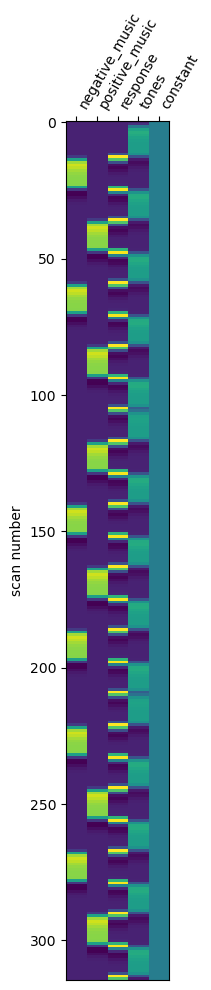

Regressor names: ['negative_music', 'positive_music', 'response', 'tones', 'constant']


In [7]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

# Get regressor names from the design matrix
regressor_names = fmri_glm.design_matrices_[0].columns.tolist()
print("Regressor names:", regressor_names)

945
Length of column_values: 315
Length of design_mat index: 315


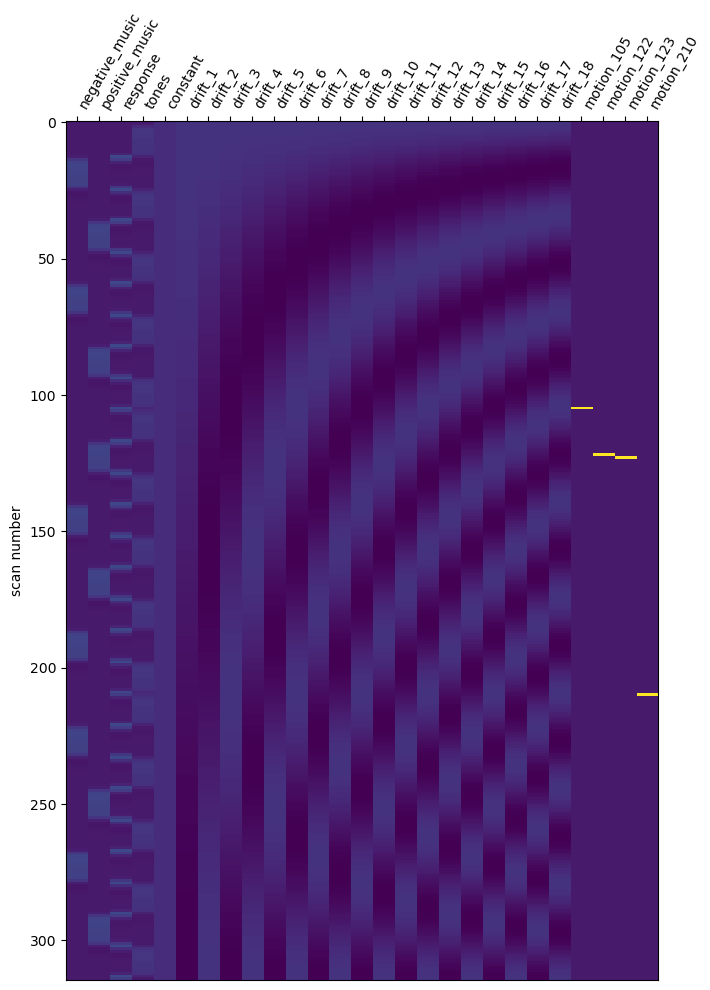

In [8]:
# Creation of the drift model:
from nilearn.glm.first_level.design_matrix import _make_drift

x = int(nbr_time_frame*TR)
print(x)
column_values, column_names = _make_drift(drift_model='cosine', frame_times=np.asarray(list(range(0, x, int(TR)))), 
                                          order=3,  
                                          high_pass=0.01) #none pour polynomial drift, 0.01 pour cosine

design_mat = fmri_glm.design_matrices_[0]

# Check the lengths of column_values and design_mat before assignment
print("Length of column_values:", column_values.shape[0])
print("Length of design_mat index:", len(design_mat))

# If there is a mismatch, trim column_values to match the length of design_mat
if column_values.shape[0] > len(design_mat):
    column_values = column_values[:len(design_mat)]
elif column_values.shape[0] < len(design_mat):
    raise ValueError("column_values is shorter than design_mat, check input parameters.")

# Assign columns to the design matrix
for (col, name) in zip(column_values.T, column_names):
    design_mat[name] = col


# Add motion regressors for specific timeframes (159 and 280)
motion_regressor_105 = np.zeros(len(design_mat))
motion_regressor_122 = np.zeros(len(design_mat))
motion_regressor_123 = np.zeros(len(design_mat))
motion_regressor_210 = np.zeros(len(design_mat))

motion_regressor_105[105] = 0.0001
motion_regressor_122[122] = 0.0001
motion_regressor_123[123] = 0.0001
motion_regressor_210[210] = 0.0001
design_mat['motion_105'] = motion_regressor_105
design_mat['motion_122'] = motion_regressor_122
design_mat['motion_123'] = motion_regressor_123
design_mat['motion_210'] = motion_regressor_210

# Plot the design matrix
plot_design_matrix(design_mat)
plt.show()


In [9]:
fit_glm = FirstLevelModel(t_r=int(TR),
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           #drift_order=2,
                           high_pass=0.01)



fit_glm.fit(fmri_img, design_matrices=[design_mat])

FirstLevelModel(hrf_model='spm', t_r=3)

In [10]:
# Get regressor names from the design matrix
regressor_names = fit_glm.design_matrices_[0].columns.tolist()
print("Regressor names:", regressor_names)
n_regressors=len(regressor_names)

# Generate the conditions dictionary
conditions = {
    regressor: np.eye(n_regressors)[i]
    for i, regressor in enumerate(regressor_names)
}

positive_minus_negative = conditions['positive_music']-conditions['negative_music']

Regressor names: ['negative_music', 'positive_music', 'response', 'tones', 'constant', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8', 'drift_9', 'drift_10', 'drift_11', 'drift_12', 'drift_13', 'drift_14', 'drift_15', 'drift_16', 'drift_17', 'drift_18', 'motion_105', 'motion_122', 'motion_123', 'motion_210']


BETA MAP FOR negative_music


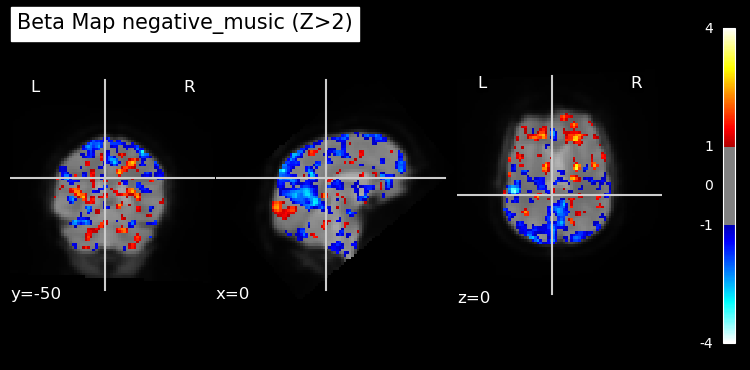

BETA MAP FOR positive_music


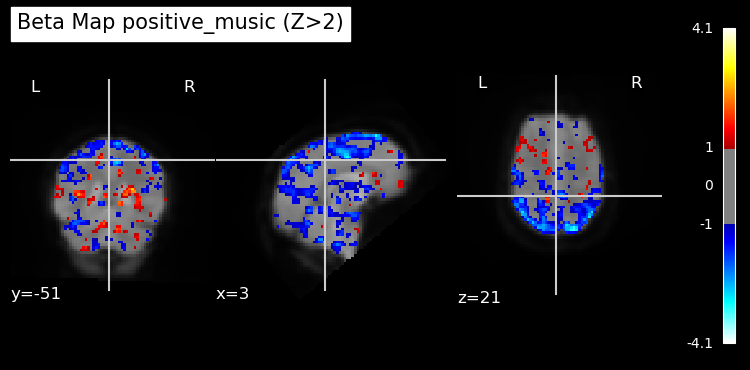

BETA MAP FOR response


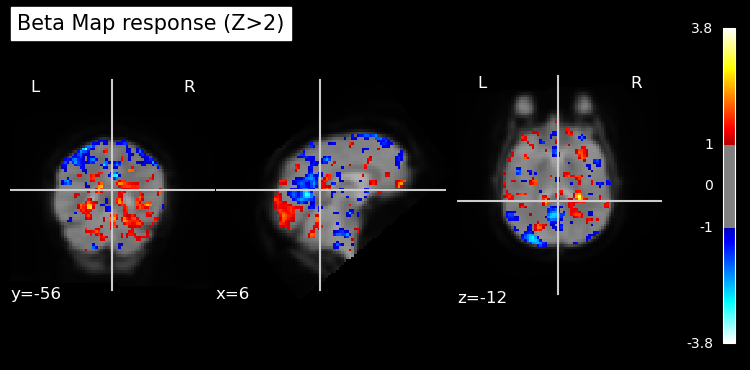

BETA MAP FOR tones


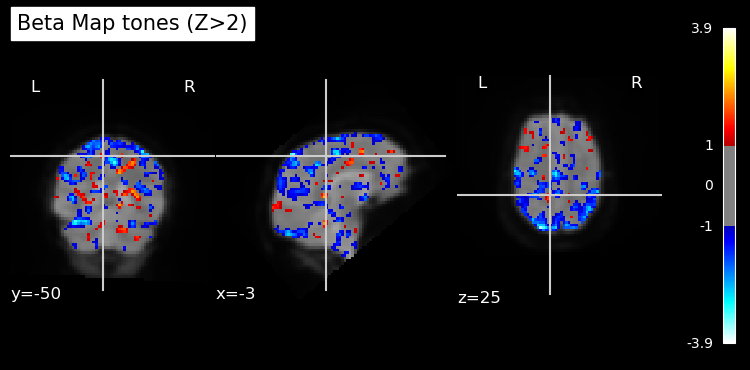

BETA MAP FOR constant


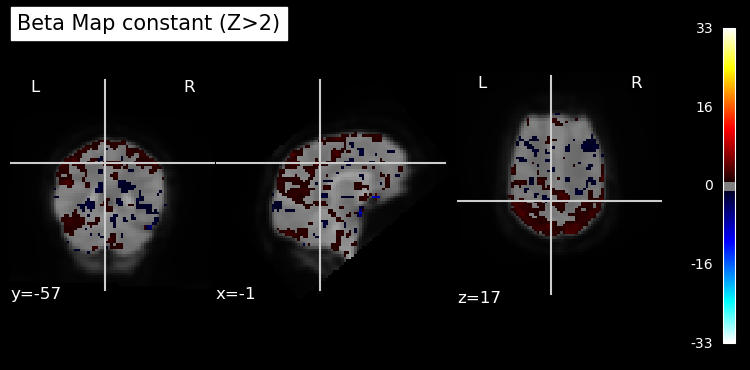

BETA MAP FOR drift_1


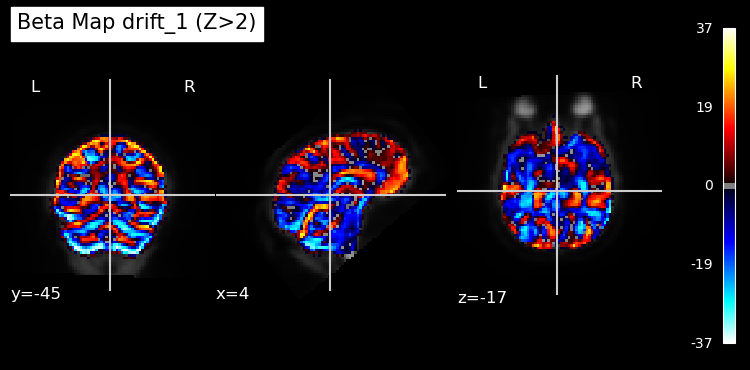

BETA MAP FOR drift_2


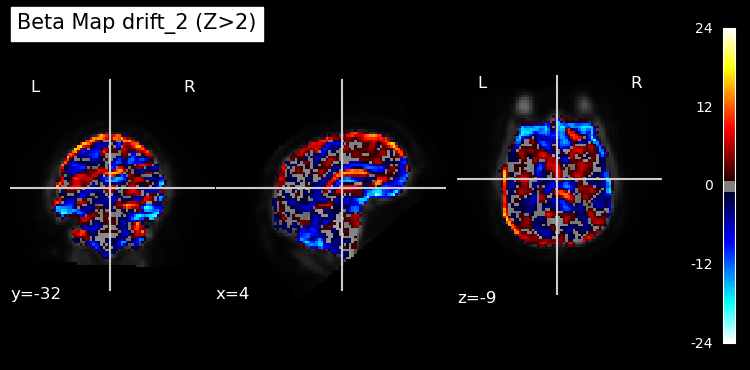

BETA MAP FOR drift_3


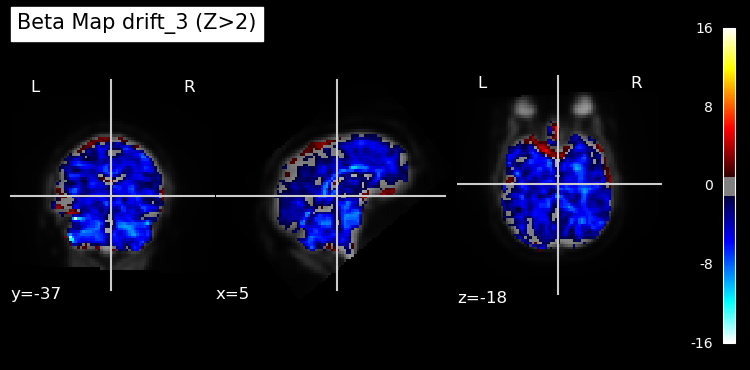

BETA MAP FOR drift_4


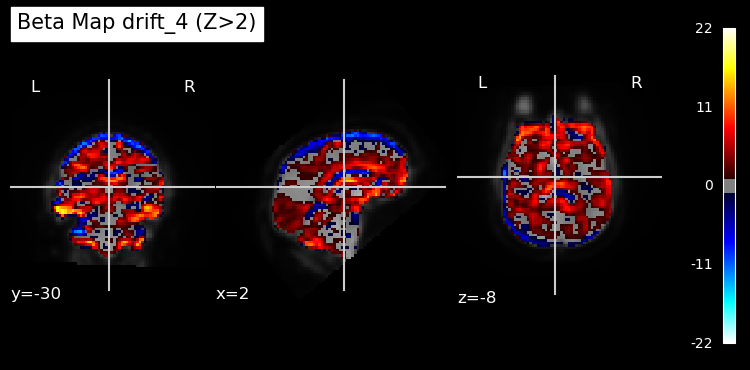

BETA MAP FOR drift_5


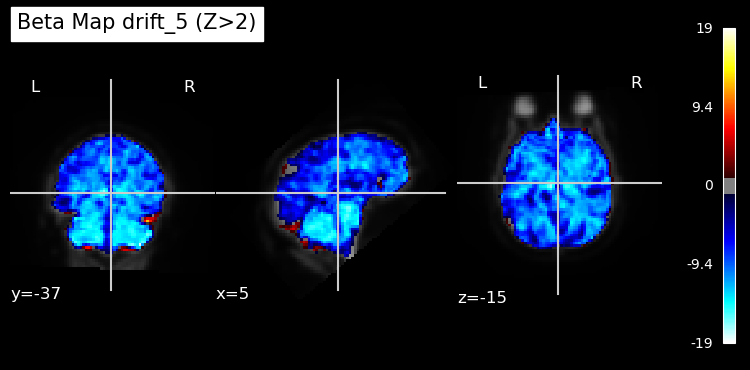

BETA MAP FOR drift_6


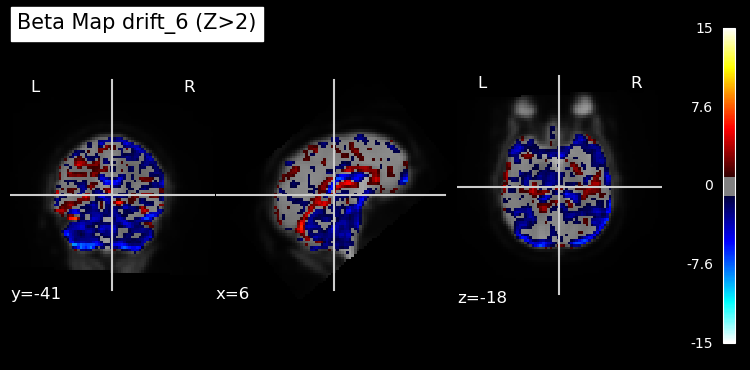

BETA MAP FOR drift_7


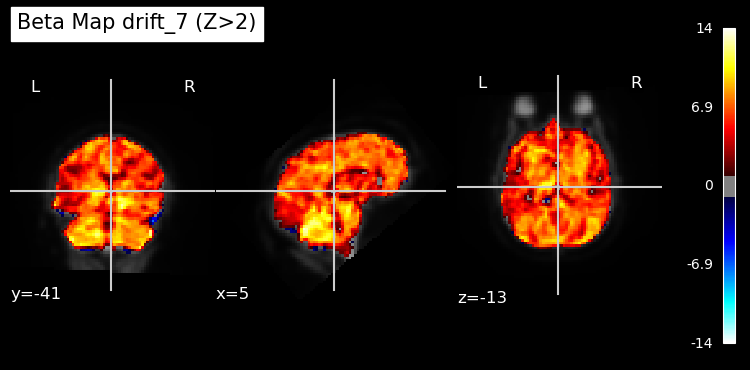

BETA MAP FOR drift_8


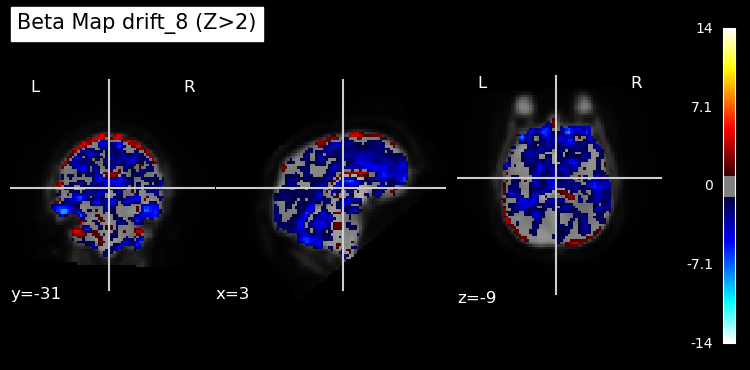

BETA MAP FOR drift_9


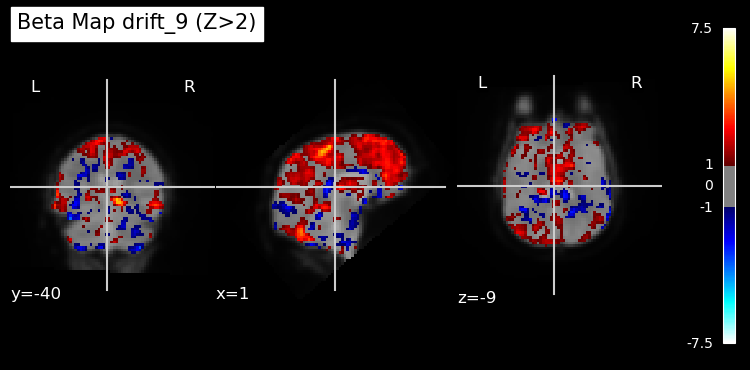

BETA MAP FOR drift_10


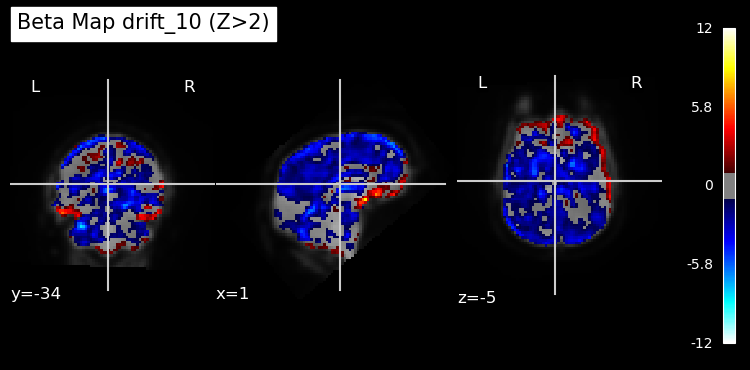

BETA MAP FOR drift_11


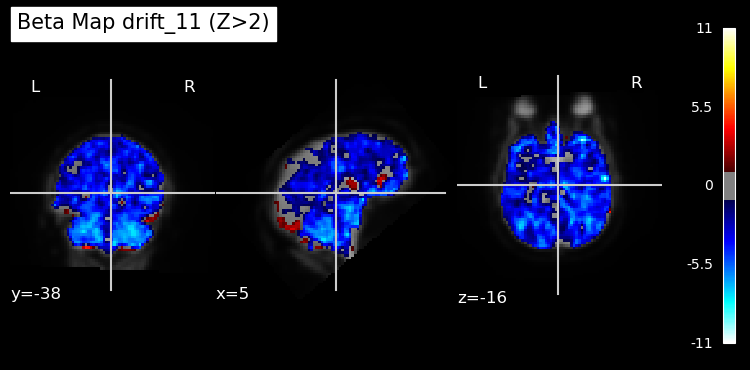

BETA MAP FOR drift_12


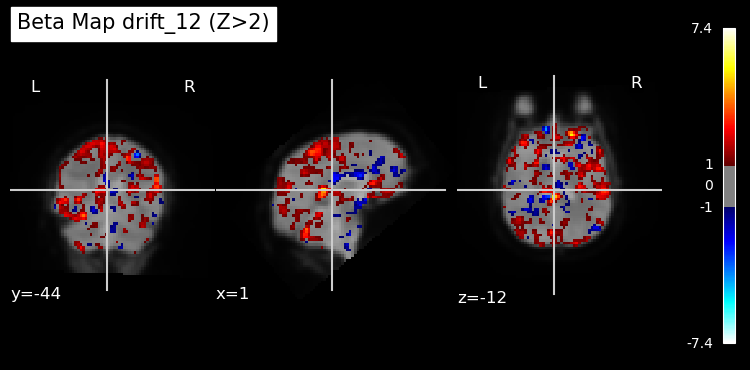

BETA MAP FOR drift_13


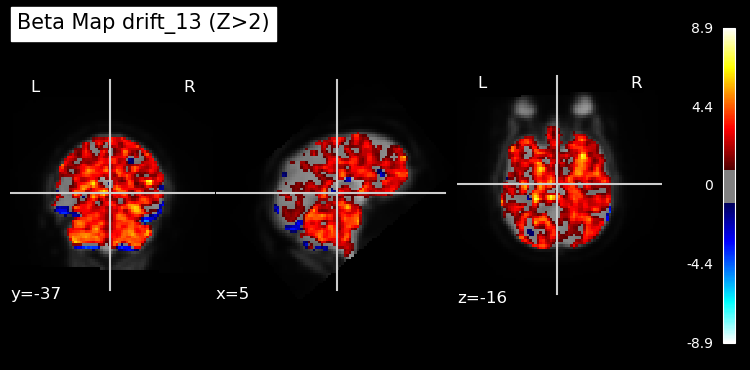

BETA MAP FOR drift_14


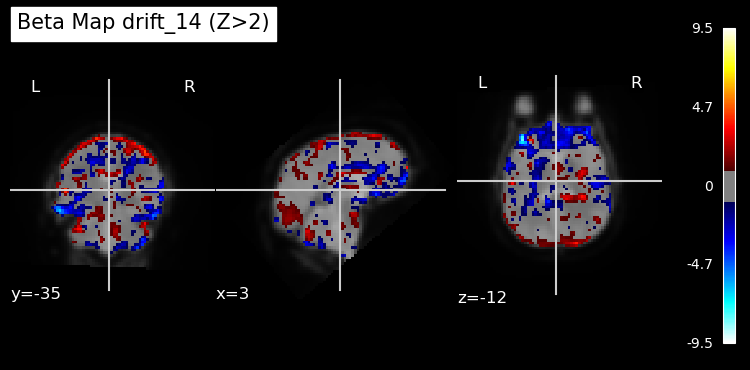

BETA MAP FOR drift_15


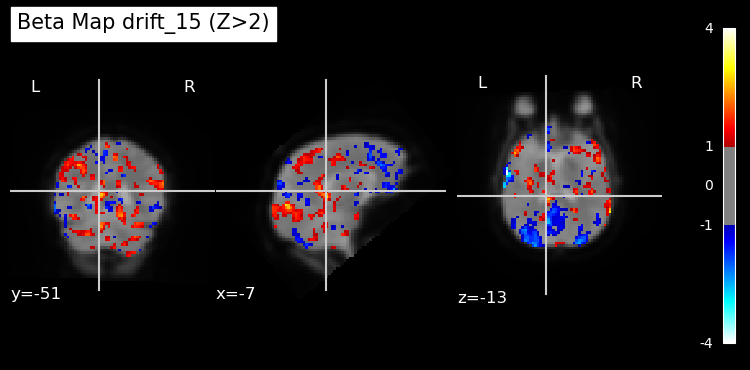

BETA MAP FOR drift_16


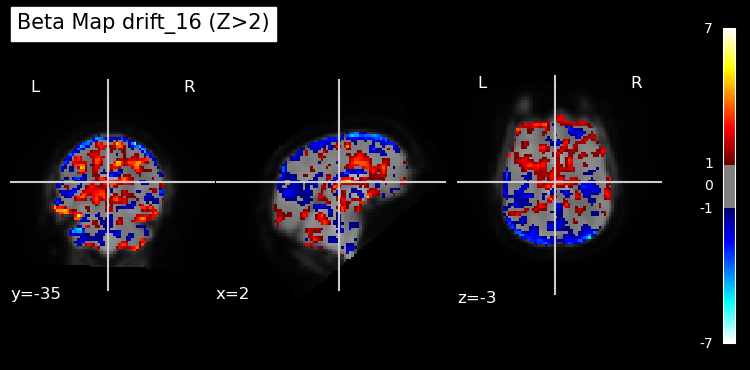

BETA MAP FOR drift_17


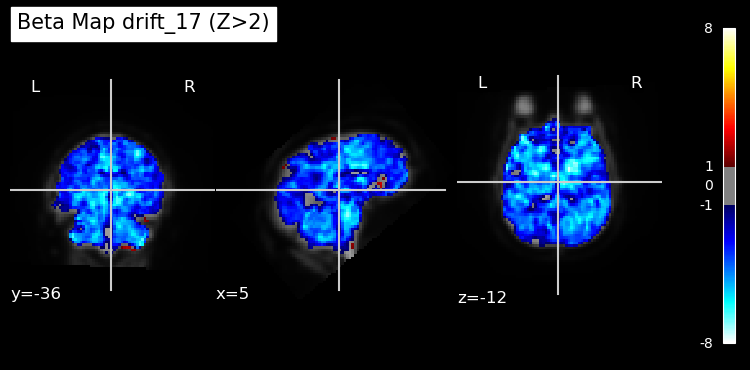

BETA MAP FOR drift_18


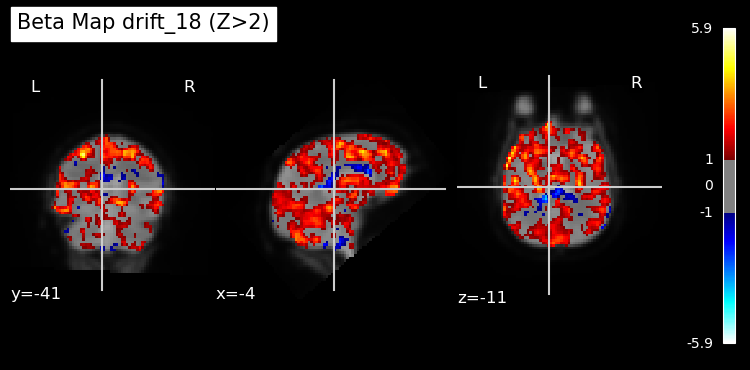

BETA MAP FOR motion_105


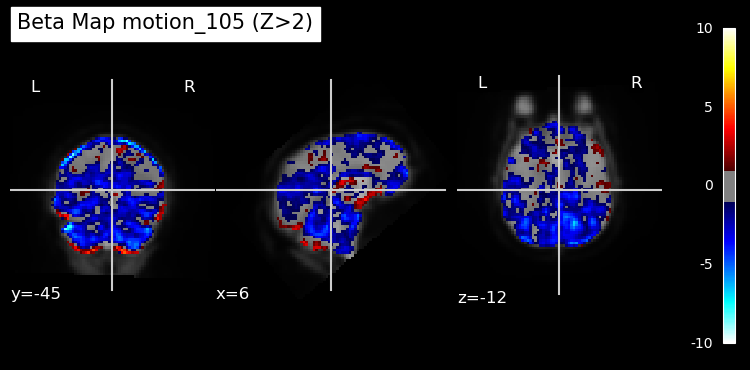

BETA MAP FOR motion_122


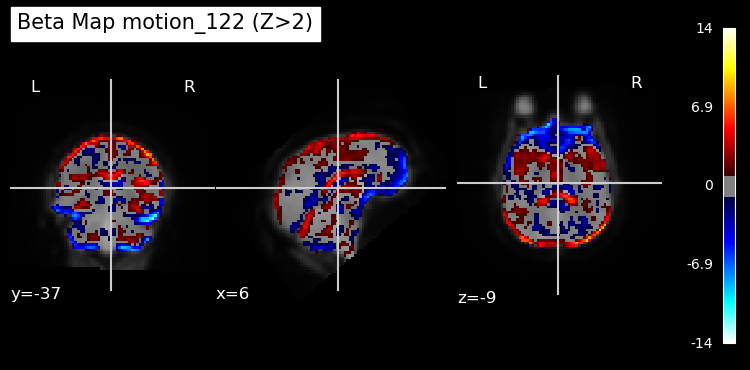

BETA MAP FOR motion_123


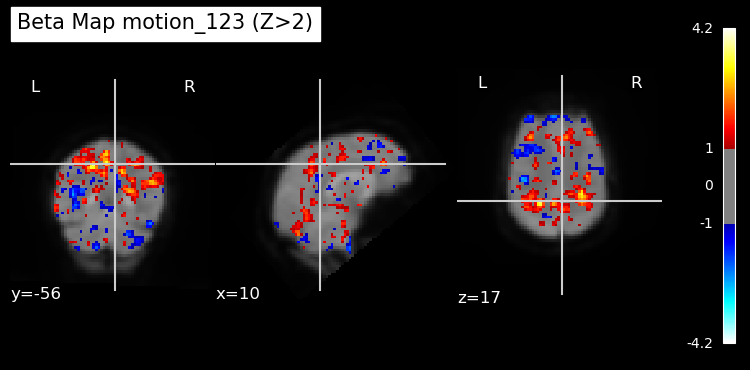

BETA MAP FOR motion_210


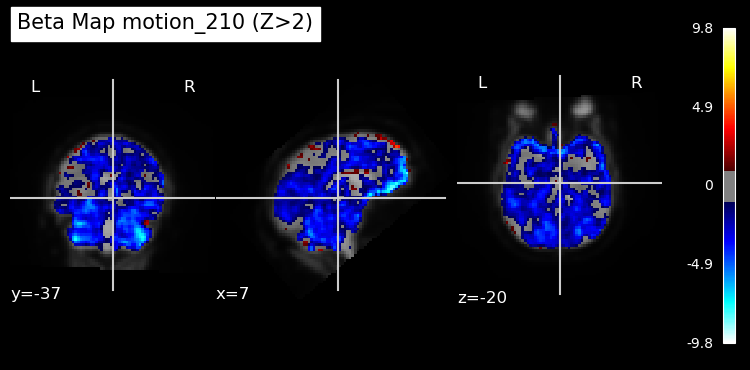

In [11]:
from nilearn.image import mean_img
from nilearn.plotting import plot_stat_map



for condition in conditions :
    regressor=conditions[condition]
    print(f'BETA MAP FOR {condition}')
    #plot_contrast_matrix(regressor, design_matrix=design_mat) 
    beta_map = fit_glm.compute_contrast(regressor,
                                  output_type='z_score')

    nib.save(beta_map, f'beta_map_{condition}.nii.gz')
    mean_img_ = mean_img(fmri_img),
    plot_stat_map(beta_map, bg_img=mean_img_[0], threshold=1,
              display_mode='ortho', 
            #cut_coords=[-50, -40, -35, -20, -10, 0, 10, 20, 30, 40], black_bg=True,
              title=f'Beta Map {condition} (Z>2)')
    plt.show()


<Axes: label='conditions'>

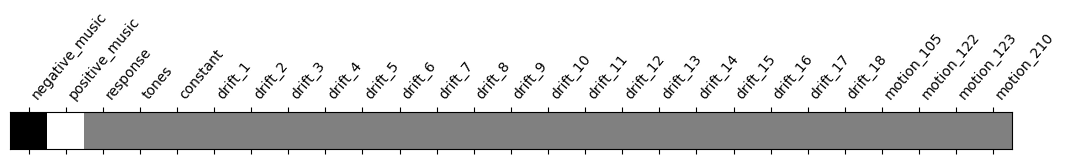

In [12]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(positive_minus_negative, design_matrix=design_mat)  ####TODO ADD COLOR SCALE

In [13]:
import nibabel as nib
z_map = fit_glm.compute_contrast(positive_minus_negative,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

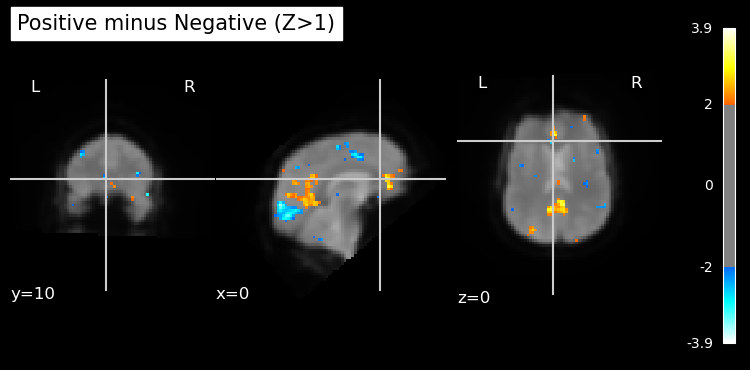

In [14]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=2,
              display_mode='ortho', cut_coords=[0, 10, 0], black_bg=True,
              title='Positive minus Negative (Z>1)')
plt.show()

In [15]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

09:21:43: Debug: Adding duplicate image handler for 'Windows bitmap file'
09:21:43: Debug: Adding duplicate animation handler for '1' type
09:21:43: Debug: Adding duplicate animation handler for '2' type
09:21:43: Debug: Adding duplicate image handler for 'Windows bitmap file'
09:21:43: Debug: Adding duplicate animation handler for '1' type
09:21:43: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:7856): Gtk-CRITICAL **: 09:21:43.669: gtk_window_resize: assertion 'height > 0' failed


In [16]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load('z_map_uncorrected.nii.gz')


(ipykernel_launcher.py:7856): Gdk-WARNING **: 09:21:44.930: gdkdrawable-x11.c:952 drawable is not a pixmap or window
09:21:44: Debug: ClientToScreen cannot work when toplevel window is not shown
09:21:44: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:7856): Gdk-WARNING **: 09:21:44.933: gdkdrawable-x11.c:952 drawable is not a pixmap or window
09:21:44: Debug: ClientToScreen cannot work when toplevel window is not shown
09:21:44: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:7856): Gdk-WARNING **: 09:21:44.936: gdkdrawable-x11.c:952 drawable is not a pixmap or window
09:21:44: Debug: ClientToScreen cannot work when toplevel window is not shown
09:21:44: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:7856): Gdk-WARNING **: 09:21:44.938: gdkdrawable-x11.c:952 drawable is not a pixmap or window
09:21:44: Debug: ClientToScreen cannot work when toplevel wi

In [17]:
# Load the AAL atlas

 #Step 2: Load the AAL Atlas
aal_atlas = fetch_atlas_aal()
aal_labels = aal_atlas.labels
print("AAL atlas regions loaded:", aal_labels)


AAL atlas regions loaded: ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusi

In [18]:
design_mat.columns.tolist()

['negative_music',
 'positive_music',
 'response',
 'tones',
 'constant',
 'drift_1',
 'drift_2',
 'drift_3',
 'drift_4',
 'drift_5',
 'drift_6',
 'drift_7',
 'drift_8',
 'drift_9',
 'drift_10',
 'drift_11',
 'drift_12',
 'drift_13',
 'drift_14',
 'drift_15',
 'drift_16',
 'drift_17',
 'drift_18',
 'motion_105',
 'motion_122',
 'motion_123',
 'motion_210']

In [19]:
import numpy as np

# Get the list of regressor names
regressor_names = design_mat.columns.tolist()
n_regressors = len(regressor_names)

# Create a zero vector
contrast_vector = np.zeros(n_regressors)

# Set +1 for 'positive_music' and -1 for 'negative_music'
contrast_vector[regressor_names.index('positive_music')] = 1
contrast_vector[regressor_names.index('negative_music')] = -1

# Print the contrast vector
print("Contrast vector (positive_minus_negative):", contrast_vector)


Contrast vector (positive_minus_negative): [-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [20]:
print("Design matrix columns:", design_mat.columns.tolist())

Design matrix columns: ['negative_music', 'positive_music', 'response', 'tones', 'constant', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8', 'drift_9', 'drift_10', 'drift_11', 'drift_12', 'drift_13', 'drift_14', 'drift_15', 'drift_16', 'drift_17', 'drift_18', 'motion_105', 'motion_122', 'motion_123', 'motion_210']


In [21]:
# Assuming 'fit_glm' is your fitted GLM model from previous steps
z_map = fit_glm.compute_contrast(contrast_vector, output_type='z_score')

# Ensure z_map is 3D
from nilearn import image

if len(z_map.shape) == 4 and z_map.shape[-1] == 1:
    z_map = image.index_img(z_map, 0)

# Save the z-map (optional)
import nibabel as nib
nib.save(z_map, 'positive_minus_negative_z_map.nii.gz')


In [27]:
from nilearn import datasets

# Load AAL atlas and extract indices and labels
aal_atlas = datasets.fetch_atlas_aal()
atlas_img = aal_atlas.maps
atlas_indices = range(1, len(aal_atlas.labels) + 1)  # Create indices starting from 1
atlas_labels = aal_atlas.labels

# Create dictionary mapping indices to labels
labels_dict = dict(zip(atlas_indices, atlas_labels))

# Example output
print(labels_dict)


{1: 'Precentral_L', 2: 'Precentral_R', 3: 'Frontal_Sup_L', 4: 'Frontal_Sup_R', 5: 'Frontal_Sup_Orb_L', 6: 'Frontal_Sup_Orb_R', 7: 'Frontal_Mid_L', 8: 'Frontal_Mid_R', 9: 'Frontal_Mid_Orb_L', 10: 'Frontal_Mid_Orb_R', 11: 'Frontal_Inf_Oper_L', 12: 'Frontal_Inf_Oper_R', 13: 'Frontal_Inf_Tri_L', 14: 'Frontal_Inf_Tri_R', 15: 'Frontal_Inf_Orb_L', 16: 'Frontal_Inf_Orb_R', 17: 'Rolandic_Oper_L', 18: 'Rolandic_Oper_R', 19: 'Supp_Motor_Area_L', 20: 'Supp_Motor_Area_R', 21: 'Olfactory_L', 22: 'Olfactory_R', 23: 'Frontal_Sup_Medial_L', 24: 'Frontal_Sup_Medial_R', 25: 'Frontal_Med_Orb_L', 26: 'Frontal_Med_Orb_R', 27: 'Rectus_L', 28: 'Rectus_R', 29: 'Insula_L', 30: 'Insula_R', 31: 'Cingulum_Ant_L', 32: 'Cingulum_Ant_R', 33: 'Cingulum_Mid_L', 34: 'Cingulum_Mid_R', 35: 'Cingulum_Post_L', 36: 'Cingulum_Post_R', 37: 'Hippocampus_L', 38: 'Hippocampus_R', 39: 'ParaHippocampal_L', 40: 'ParaHippocampal_R', 41: 'Amygdala_L', 42: 'Amygdala_R', 43: 'Calcarine_L', 44: 'Calcarine_R', 45: 'Cuneus_L', 46: 'Cuneus_

In [28]:
labels_dict = dict(zip(atlas_indices, atlas_labels))

In [29]:
# Get the MNI coordinates of the maximum z-score
z_data = z_map.get_fdata()
max_z = np.nanmax(z_data)
max_coords_voxel = np.unravel_index(np.nanargmax(z_data), z_data.shape)
max_coords_mni = nib.affines.apply_affine(z_map.affine, max_coords_voxel)

print(f"Maximum z-score: {max_z}")
print(f"Voxel coordinates: {max_coords_voxel}")
print(f"MNI coordinates: {max_coords_mni}")


Maximum z-score: 3.8743234381356455
Voxel coordinates: (49, 18, 35)
MNI coordinates: [ -19.4179434  -108.10522206  -22.5393508 ]


In [30]:
import nibabel as nib
import numpy as np
from nilearn import plotting, datasets, image, masking
from nilearn.input_data import NiftiLabelsMasker

# Load the AAL atlas and labels
aal_atlas = datasets.fetch_atlas_aal()
atlas_img = aal_atlas.maps
labels = aal_atlas.labels

# Load your contrast map
contrast_img = nib.load('positive_minus_negative_z_map.nii.gz')

# Apply masking to extract the maximal activation region
masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
time_series = masker.fit_transform(contrast_img)
mean_contrast_values = np.mean(time_series, axis=0)

# Identify the index of the region with the maximum contrast
max_region_index = np.argmax(mean_contrast_values)
max_region_name = labels[max_region_index]  # Retrieve the corresponding region name

# Output the results
if max_region_name == "Unknown":
    print("Region with maximal contrast is labeled as 'Unknown'. Please verify atlas alignment.")
else:
    print(f"The region with maximal contrast is: {max_region_name}")


The region with maximal contrast is: Vermis_7


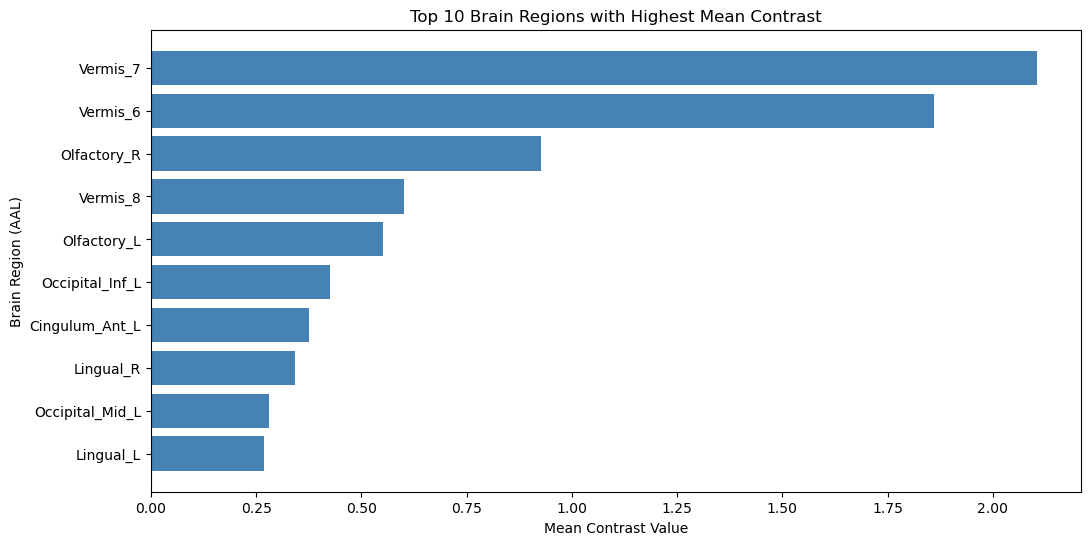

['Vermis_7' 'Vermis_6' 'Olfactory_R' 'Vermis_8' 'Olfactory_L'
 'Occipital_Inf_L' 'Cingulum_Ant_L' 'Lingual_R' 'Occipital_Mid_L'
 'Lingual_L']
[2.10393675 1.85954193 0.92654431 0.6016381  0.55078211 0.42627065
 0.37657089 0.34239394 0.28113227 0.26776347]


In [42]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, datasets, image
from nilearn.input_data import NiftiLabelsMasker

# Load the AAL atlas and labels
aal_atlas = datasets.fetch_atlas_aal()
atlas_img = aal_atlas.maps
labels = aal_atlas.labels

# Load your contrast map
contrast_img = nib.load('positive_minus_negative_z_map.nii.gz')

# Apply masking to extract the mean contrast values for each region
masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
time_series = masker.fit_transform(contrast_img)
mean_contrast_values = np.mean(time_series, axis=0)

# Identify top regions
sorted_indices = np.argsort(mean_contrast_values)[::-1]
sorted_contrast_values = mean_contrast_values[sorted_indices]
sorted_labels = np.array(labels)[sorted_indices]

# Plot bar chart for the top 10 regions
plt.figure(figsize=(12, 6))
plt.barh(sorted_labels[:10], sorted_contrast_values[:10], color='steelblue')
plt.xlabel("Mean Contrast Value")
plt.ylabel("Brain Region (AAL)")
plt.title("Top 10 Brain Regions with Highest Mean Contrast")
plt.gca().invert_yaxis()
plt.show()
print(sorted_labels[:10])
print( sorted_contrast_values[:10])

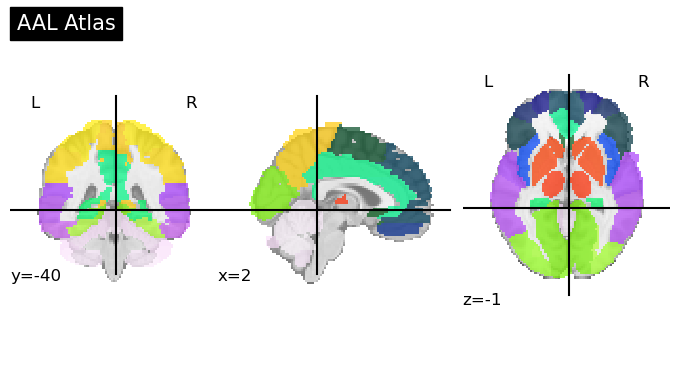

In [33]:
from nilearn import datasets, plotting
import nibabel as nib
import matplotlib.pyplot as plt

# Load the AAL atlas
aal_atlas = datasets.fetch_atlas_aal()
atlas_img = nib.load(aal_atlas.maps)

# Plot the atlas
plotting.plot_roi(atlas_img, title='AAL Atlas', display_mode='ortho')
plt.show()
